# Step 2: Clean Network

This is a further post-processing function now found within the network_clean GOSTnets submodule. This function cleans the network by removing excessive nodes, and ensures all edges are bi-directional (except in the case of one-way roads).

WARNING: The Clean Network function is a computationally expensive function, so it may take a while to run. It outputs a pickled graph object, a dataframe of the edges, and a dataframe of the nodes. The expectation is that this will only have to be run once.

In [1]:
import os, sys
import time
import networkx as nx

In [2]:
# add to your system path the location of the LoadOSM.py and GOSTnet.py scripts
sys.path.append("../")
import GOSTnets as gn

In [3]:
pth = "./" # change this path to your working folder
data_pth = os.path.join(pth, 'tutorial_outputs')

# read back your graph from step 1 from you saved pickle
G = nx.read_gpickle(os.path.join(data_pth, 'iceland_unclean.pickle'))

In [4]:
# inspect the graph
nodes = list(G.nodes(data=True))
edges = list(G.edges(data=True))
print(len(nodes))
print(nodes[0])
print(len(edges))
print(edges[0])

16115
(0, {'x': -21.7138473, 'y': 64.1680006})
19463
(1, 6849, {'Wkt': <shapely.geometry.linestring.LineString object at 0x000001C3B78C5438>, 'id': 8559, 'infra_type': 'residential', 'osm_id': '108524343', 'key': 'edge_8559', 'length': 0.06716756626000746})


In [5]:
# you can also print general graph information with networkx
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 16115
Number of edges: 19463
Average in degree:   1.2078
Average out degree:   1.2078


In [8]:
# To become familiar with the function read the doc string
gn.clean_network?

Set up some parameters for the CleanNetwork function

In [7]:
Iceland_UTMZ = {'init': 'epsg:32627'}

WGS = {'init': 'epsg:4326'} # do not adjust. OSM natively comes in ESPG 4326

Run the CleanNetwork Function.  
Changing verbose to True will write the outputs in the specified wpath.

In [9]:
print('start: %s\n' % time.ctime())
G_clean = gn.clean_network(G, UTM = Iceland_UTMZ, WGS = {'init': 'epsg:4326'}, junctdist = 10, verbose = False)

# using verbose = True:
# G_clean = gn.clean_network(G, wpath = data_pth, output_file_name = 'iceland_network', UTM = Iceland_UTMZ, WGS = {'init': 'epsg:4326'}, junctdist = 10, verbose = True)
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

start: Mon Feb 24 17:46:49 2020



C:\WBG\Anaconda\envs\network-analysis\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\WBG\Anaconda\envs\network-analysis\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\WBG\Anaconda\envs\network-analysis\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 +type=crs != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


14486
27151
12708
24611
Edge reduction: 19463 to 24611 (-26 percent)

end: Mon Feb 24 17:47:41 2020

--- processing complete


In [10]:
# let's print info on our clean version
print(nx.info(G_clean))

Name: 
Type: MultiDiGraph
Number of nodes: 9678
Number of edges: 24611
Average in degree:   2.5430
Average out degree:   2.5430


The clean_network function helps snapping points that are very close to one another. However, it does not conduct any check on whether the network is fully connected.

## Optional step: Only use the largest sub-graph
Network analysis is often done on only connected graphs. Disconnected graphs can result in paths that cannot reach their destination. Also, you can evaluate how connected your network is and have the option of going back and making more edits.

In [11]:
# Identify only the largest graph

# compatible with NetworkX 2.4
list_of_subgraphs = list(G_clean.subgraph(c).copy() for c in nx.strongly_connected_components(G_clean))
max_graph = None
max_edges = 0
for i in list_of_subgraphs:
    if i.number_of_edges() > max_edges:
        max_edges = i.number_of_edges()
        max_graph = i

# set your graph equal to the largest sub-graph
G_largest = max_graph

In [12]:
# print info about the largest sub-graph
print(nx.info(G_largest))

Name: 
Type: MultiDiGraph
Number of nodes: 9583
Number of edges: 24491
Average in degree:   2.5557
Average out degree:   2.5557


The majority of the network was captured by the largest subgraph. That's pretty good. It means the quality of OSM data for this city is quite good.  

Save this prepared graph in your output folder: 

In [15]:
gn.save(G_largest, "iceland_network_clean", data_pth)

C:\WBG\Anaconda\envs\network-analysis\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


How many subgraphs would you guess there are?

In [17]:
len(list_of_subgraphs)

37

Move on to Step 3 to see how we can use this network for some travel time analysis!

#### Optional: Compare networks (original / clean-version / largest subgraph)

OSMNX is one of the key libraries that GostNETS is based on. Here, we load it to access graph-plotting functions.

In [18]:
import osmnx as ox

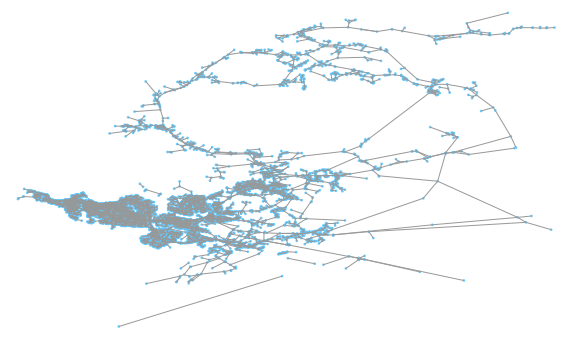

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c3bb447a58>)

In [19]:
# plotting functions only work if the graphs have a name and a crs attribute
G.graph['crs'] = 'epsg:32646'
G.graph['name'] = 'Iceland'

# original graph
ox.plot_graph(G, fig_width=10, edge_linewidth=1, node_size=7)

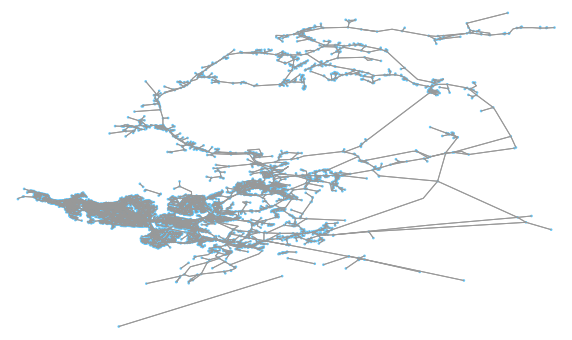

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c3bb70d550>)

In [20]:
G_clean.graph['crs'] = 'epsg:32646'
G_clean.graph['name'] = 'Iceland'

# cleaned graph
ox.plot_graph(G_clean, fig_width=10, edge_linewidth=1, node_size=7)

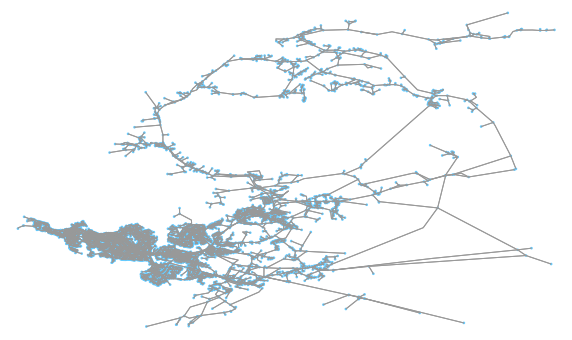

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c3baa97a20>)

In [21]:
G_largest.graph['crs'] = 'epsg:32646'
G_largest.graph['name'] = 'Iceland'

# largest subgraph
ox.plot_graph(G_largest, fig_width=10, edge_linewidth=1, node_size=7)